---
#### **Projeto parte do Curso: Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [30]:
# instalar Pandas Profiling
!pip install scikit-plot -q
!pip install imbalanced-learn -q

In [31]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

# importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, classification_report
from scikitplot.metrics import plot_confusion_matrix, plot_roc
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.svm import SVC
from lightgbm import LGBMClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# random seed
np.random.seed(42)

# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/alexandre-ferreira-1986/DataScience/main/data/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Instruções para o modelo de churn prediction

ENTENDA O SEU PROBLEMA
* Olhar o todo e delimitar o escopo do projeto
* Como a solução vai ser usada?
* Quais são as soluções já existentes?
* Qual abordagem usar?
    * Aprendizado Supervisionado
    * Aprendizado Não Supervisionado
    * Aprendizado Por Reforço
* Qual é a métrica de performance?
* Qual a performance mínima esperada para atingir o objetivo?
* Liste as premissas básicas do projeto
* Pesquise sobre *churn rate* no Google
* Veja os serviços que outras empresas de Telecom oferecem 

EXPLORAR OS DADOS
* Estudar cada atributo e suas características:
    * Nome
    * Tipo
        * Categórica
        * Numérica
            * int
            * float
        * Estruturada
        * Não Estruturada
        * etc
    * % de valores ausentes
    * Ruído nos dados e tipo de ruído (outliers, estocásticos, erros de arredondamento)
    * Tipo de distribuição
        * Gaussiana
        * Uniforme
        * Logarítmica
        * etc
* Identificar a variável alvo (target)
* Visualizar os dados
* Estudar a correlação entre os dados
* Ver o balanceamento das classes
* Identificar as transformações que podem ser aplicadas
* Identificar os dados extras que podem ser úteis


PREPARAÇÃO DOS DADOS
* Limpeza dos Dados
    * Consertar ou remover outliers
    * Preencher os valores faltantes ou eliminar as linhas/colunas
        * Zero
        * Média
        * Mediana
        * Frequência
* Seleção de atributos
    * Eliminar os atributos (*features*) que não contêm informações úteis

* *Feature Engineering*
    * Discretizar variáveis contínuas
    * Decompor *features* (categóricas, data, tempo)
    * Aplicar transformações às variáveis
    * Agregar *features* para gerar novas
    
* *Feature Scaling*
    * Normalizar ou padronizar *features*

* Dividir entre treino, teste e validação

CONSTRUIR MODELO(S) DE MACHINE LEARNING
* Analisar as variáveis mais significativas para cada algoritmo
* *Hyperparameters Tuning* (se necessário)
* Uso de *cross-validation*
* Verificar o desempenho do(s) modelo(s) e considerar métodos *Ensemble*

## Análise Exploratória dos Dados

Após visualizarmos o Dataset, vamos conhecer um pouco mais, checando a quantidade de entradas do mesmo:

In [32]:
print("Linhas:  {}".format(df.shape[0]))
print("Colunas: {}".format(df.shape[1]))

Linhas:  7043
Colunas: 21


Inicialmente vamos checar quais os tipos de variáveis em cada coluna do Dataset:

In [33]:
# Analisando os tipos de variáveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


Agora, vamos checar a integridade do Dataset.

A verificação da quantidade de valores ausentes nos permitirá checar esta integridade.

In [34]:
#Checar dados ausentes no Dataset todo
print("Dados ausentes (total):\t{}\n".format(df.isnull().sum().values.sum()))

# Checar dados ausentes por coluna
print(df.isnull().sum() / df.shape[0])

Dados ausentes (total):	0

customerID          0.0
gender              0.0
SeniorCitizen       0.0
Partner             0.0
Dependents          0.0
tenure              0.0
PhoneService        0.0
MultipleLines       0.0
InternetService     0.0
OnlineSecurity      0.0
OnlineBackup        0.0
DeviceProtection    0.0
TechSupport         0.0
StreamingTV         0.0
StreamingMovies     0.0
Contract            0.0
PaperlessBilling    0.0
PaymentMethod       0.0
MonthlyCharges      0.0
TotalCharges        0.0
Churn               0.0
dtype: float64


In [35]:
# Checar quantos valores únicos há por coluna
print("Valores únicos (por coluna): \n{}".format(df.nunique()))

Valores únicos (por coluna): 
customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64


Observações importantes:

- A variável "Churn" é a coluna alvo da análise
- A coluna `TotalChargers` deveria ser um float, mas é uma `String`

In [36]:
# Converter a coluna TotalChargers para Float
#df['TotalCharges'].astype('float32')

O erro se dá principalmente porque os valores ausentes foram lançados como string.

In [37]:
def converter_str_float(entrada):
    """
    Converte um objeto do tipo string em float.

    # Arguments
        entrada: string, string da coluna TotalCharges.

    # Returns
        Valor convertido em float, caso permita a conversão.
        NaN, caso o valor não seja apropriado.
    """

    try:
        return float(entrada)
    except ValueError:
        return np.nan

# criar cópia do dataframe
df_clean = df.copy()

# converter as strings de TotalCharges para float
df_clean["TotalCharges"] = df_clean["TotalCharges"].apply(converter_str_float)

# verificar entradas ausentes
print("Dados ausentes em 'TotalCharges' (antes):\t{}\n".format(df_clean["TotalCharges"].isnull().sum()))

# substituir os dados ausentes pelo valor da mediana
TotalChargesMedian = df_clean.TotalCharges.median()
df_clean["TotalCharges"].fillna(TotalChargesMedian, inplace=True)

Dados ausentes em 'TotalCharges' (antes):	11



In [38]:
# remover coluna costumerID, já que não necessitamos da mesma
df_clean.drop("customerID", axis=1, inplace=True)

In [39]:
# Analisando o novo Dataset:
df_clean.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2281.916928
std,0.368612,24.559481,30.090047,2265.270398
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,402.225000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


A partir da análise acima, vamos checar se há a presença de outliers, principalmente nas colunas `MonthlyCharges` e `TotalCharges`

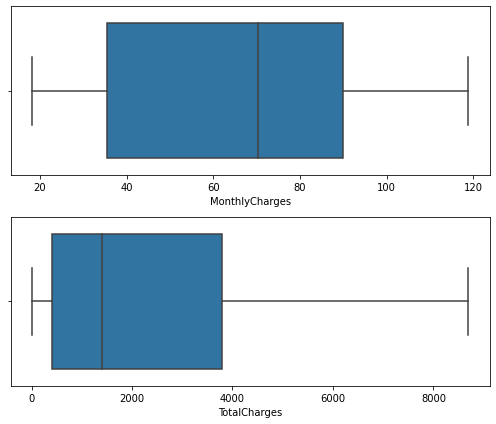

In [40]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(7, 6))
sns.boxplot(df_clean['MonthlyCharges'], ax=ax[0])
sns.boxplot(df_clean['TotalCharges'], ax=ax[1])
plt.tight_layout()

A variável `Tenure` está relacionada com o tempo que um cliente permanece assinando determinado serviço.

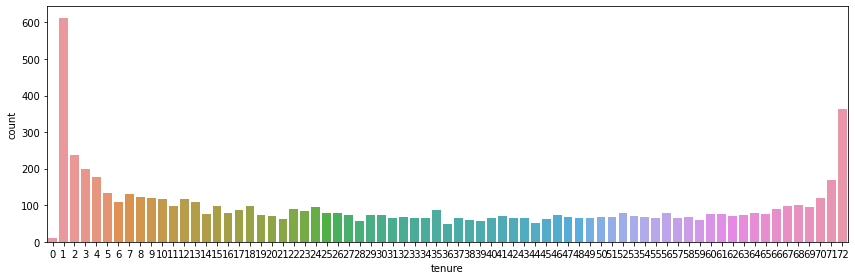

In [41]:
fig, ax = plt.subplots(figsize=(12, 4))
sns.countplot(df['tenure'])
plt.tight_layout()

Quando lidamos com variáveis categóricas, é importante checarmos quais labels estão relacionados com cada coluna.
Na análise abaixo, podemos perceber que `No`, `No phone service`, `No internet service`, aparentam indicar o mesmo sentido.

In [42]:
# Analisando valores únicos das variáveis categóricas
np.unique(df_clean.select_dtypes('object').values)

array(['Bank transfer (automatic)', 'Credit card (automatic)', 'DSL',
       'Electronic check', 'Female', 'Fiber optic', 'Mailed check',
       'Male', 'Month-to-month', 'No', 'No internet service',
       'No phone service', 'One year', 'Two year', 'Yes'], dtype=object)

Análise de Viés

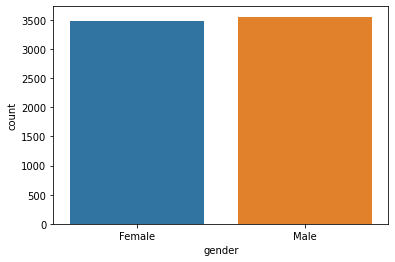

In [43]:
# Analisando a distribuição dos dados por Gênero
sns.countplot(df.gender);

Como a principal coluna do Dataset é a coluna `Churn`, vamos checar a distribuição da mesma.

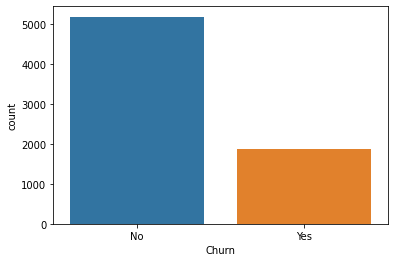

In [44]:
sns.countplot(df.Churn)

---
Podemos observar que há um desbalanceamento nos dados.

---

## Preparação dos Dados

Os seguintes passos serão dados nesta fase:

1. Serão identificadas as colunas que possuem 2 Labels únicos, e será criada uma lista com essas colunas.
2. Criar uma cópia do Dataframe, para trabalharmos com mais segurança
3. Aplicar o `LabelEncoder`, que irá transformar as variáveis binárias
4. Transformar essas colunas para colunas categóricas com múltiplas classes, através do `get_dummies`

In [45]:
# Passo 1
binary_var = df_clean.nunique()[df_clean.nunique() == 2].keys().tolist()
num_var = [col for col in df_clean.select_dtypes(['int', 'float']).columns.tolist() if col not in binary_var]
cat_var = [col for col in df_clean.columns.tolist() if col not in binary_var + num_var]

# Passo 2
df_proc = df_clean.copy()

# Passo 3
le = LabelEncoder()
for i in binary_var:
    df_proc[i] = le.fit_transform(df_proc[i])

# Passo 4
df_proc = pd.get_dummies(df_proc, columns=cat_var)

# Checar as 5 primeiras entradas do Dataframe processado
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


## Modelo de Machine Learning

Após conhecermos nosso Dataset e processarmos os dados, chegou a hora de criar o Modelo de Machine Learning.

O primeiro passo será separar os dados de Treino e de Teste.

In [46]:
# separar a feature matrix da target vector
X = df_proc.drop('Churn', axis=1)
y = df_proc['Churn']

# dividir os dados entre treino e teste.
X_train, X_test, y_train, y_test = train_test_split(X, y)

Vamos analisar alguns modelos e comparar o desempenho, para checar qual poderemos utilizar neste projeto. Os modelos analisados serão:

- Random Forest
- Decision Tree
- Stochastic Gradient
- SVC
- Regressao Logistica
- XGB
- LightGBM

In [48]:
#  padronizar os  dados,
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)

# Para quem quiser, pesquisa sobre SMOTE
# oversample = SMOTE()
# X_train, y_train = oversample.fit_sample(X_train, y_train)

rus = RandomUnderSampler()
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

In [49]:
# 1. Modelo Random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
scaler = preprocessing.StandardScaler().fit(X_train_rus)
X_train_transformed = scaler.transform(X_train_rus)
clf = make_pipeline(preprocessing.StandardScaler() , RandomForestClassifier())
scores = cross_val_score(clf, X, y, cv=5)
scores.mean()

0.790432648880573

In [50]:
# 2. Modelo decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
clf_2 = make_pipeline(preprocessing.StandardScaler() , DecisionTreeClassifier())
scores_2 = cross_val_score(clf_2, X, y, cv=5)
scores_2.mean()

0.728524924995161

In [51]:
# 3. Modelo Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier
sgdc = SGDClassifier()
clf_3 = make_pipeline(preprocessing.StandardScaler() , SGDClassifier())
scores_3 = cross_val_score(clf_3, X, y, cv=5)
scores_3.mean()

0.771121624782244

In [52]:
# 4. Modelo SVC
from sklearn.svm import SVC
svc = SVC()
clf_4 = make_pipeline(preprocessing.StandardScaler() , SVC())
scores_4 = cross_val_score(clf_4, X, y, cv=5)
scores_4.mean()

0.7985236950771017

In [53]:
# 6. Modelo xgb
from xgboost import XGBClassifier
xgb = XGBClassifier()
clf_6 = make_pipeline(preprocessing.StandardScaler() , XGBClassifier())
scores_6 = cross_val_score(clf_6, X, y, cv=5)
scores_6.mean()

0.8042034969998063

In [54]:
# 7. Modelo LightGBM
from lightgbm import LGBMClassifier
lgbm = LGBMClassifier()
clf_7 = make_pipeline(preprocessing.StandardScaler() , LGBMClassifier())
scores_7 = cross_val_score(clf_7, X, y, cv=5)
scores_7.mean()

0.7961111402348539

### Alternativa

Uma alternativa seria criar uma função para realizar a validação destes dados acima:

In [55]:
def val_model(X, y, clf, quite=False):
    """
    Realiza cross-validation com os dados de treino para determinado modelo.

    # Arguments
        X: DataFrame, contém as variáveis independetes.
        y: Series, vetor contendo a variável alvo.
        clf: modelo classificador do Scikit-learn.
        quite: bool, indicando se a função deve imprimir os resultados ou não.

    # Returns
        float, média dos scores da cross-validation.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(StandardScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if quite == False:
        print("Recall: {:.2f} (+/- {:.2f})".format(scores.mean(), scores.std()))
    
    return scores.mean()

In [56]:
# instanciar modelos
rf = RandomForestClassifier()
dt = DecisionTreeClassifier()
sgdc = SGDClassifier()
svc = SVC()
lr = LogisticRegression()
xgb = XGBClassifier()
lgbm = LGBMClassifier()

model = []
recall = []
# avaliar o desempenho (recall)
for clf in (rf, dt, sgdc, svc, lr, xgb, lgbm):
    model.append(clf.__class__.__name__)
    recall.append(val_model(X_train_rus, y_train_rus, clf, quite=True))

pd.DataFrame(data=recall, index=model, columns=['Recall'])

,Recall
RandomForestClassifier,0.758993
DecisionTreeClassifier,0.691367
SGDClassifier,0.774820
SVC,0.794964
LogisticRegression,0.805755
XGBClassifier,0.802878
LGBMClassifier,0.767626


Após as 2 análises acima, chegamos a conclusão de que podemos utilizar o XGBoost.

Apesar de a Regressão Logística apresentar um desempenho minimamente melhor, a escolha do CGBoost se dá pois poderemos personalizar melhor os Hiperparâmetros.

## Otimização do Modelo - XGBoost

In [73]:
# Otimizando: n_estimators
xgb = XGBClassifier(learning_rate=0.001)

param_grid = {
 'n_estimators':range(0,200,50),
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.7971223021582734 para {'n_estimators': 50}


Considerando o `n_estimator` = 50, vamos checar os melhores parametros para `max_depth` e `min_child_weight`

In [75]:
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50)
param_grid = {'max_depth':range(10)}           
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus , y_train_rus)
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8812949640287769 para {'max_depth': 1}


In [76]:
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50 , max_depth=1)
param_grid = {'min_child_weight':range(10)}           
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus , y_train_rus)
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.8812949640287769 para {'min_child_weight': 0}


In [77]:
# Analisar o melhor valor para Learning_rate
xgb = XGBClassifier(n_estimators=150, max_depth=1, min_child_weight=0, gamma=0.0)

param_grid = {
 'learning_rate':[0.001, 0.01, 0.1, 1]
}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train_rus, y_train_rus)

# ver resultados
print("Melhor: {} para {}".format(grid_result.best_score_, grid_result.best_params_))

Melhor: 0.881294964028777 para {'learning_rate': 0.001}


              precision    recall  f1-score   support

           0       0.94      0.57      0.71      1282
           1       0.44      0.90      0.59       479

    accuracy                           0.66      1761
   macro avg       0.69      0.73      0.65      1761
weighted avg       0.80      0.66      0.68      1761

AUC: 0.7336



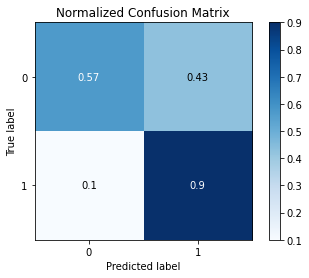

In [78]:
# modelo final
xgb = XGBClassifier(learning_rate=0.001 , n_estimators=50, max_depth=1, min_child_weight=0)
xgb.fit(X_train_rus, y_train_rus)

# fazer a previsão
X_test = scaler.transform(X_test)
y_pred = xgb.predict(X_test)

# Classification Report
print(classification_report(y_test, y_pred))

# imprimir a área sob a curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))

# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

## Conclusão

A otimização dos parâmetros conseguiu ajustar o modelo para apresentar desempenho similar ao realizado com dados de treino.

Sempre é possível reajustar os hiperparâmetros para conseguir um modelo mais ajustado, vai depender sempre da precisão que você realmente quer e da capacidade de processamento disponível.